In [ ]:
install.packages("caret")
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice



In [ ]:
install.packages("glmnet")
library(glmnet)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’


Loading required package: Matrix

Loaded glmnet 4.1-10



In [ ]:
install.packages("kernlab")
library(kernlab)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha




In [ ]:
install.packages("rpart")
library(rpart)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("rpart.plot")
library(rpart.plot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
class_names <- c("Low LTV", "High LTV")

# Callable Function for Models

In [ ]:
#-------------------------------------------------
# Helper: map scaling choice to caret preProcess
#-------------------------------------------------
get_preprocess_vec <- function(s) {
  s <- tolower(s)
  if (s == "minmax") {
    "range"            # min–max scaling
  } else {
    c("center", "scale")  # standardization
  }
}


# Regularized Linear Regression

In [ ]:
# using all non monetary regressors in model to try and predict SUPPORT TICKETS RAISED (flag for LOW LTV CUSTOMER)

# will ALSO try to use this to predict CUSTOMER SATISFACTION SCORE (flag for HIGH LTV CUSTOMER)

In [ ]:
train_linear_model <- function(X_train, y_train, scale = "standard") {
  preproc_vec <- get_preprocess_vec(scale)

  C_vals      <- c(0.001, 0.01, 0.1, 1, 10)
  lambda_vals <- 1 / C_vals

  tune_grid <- expand.grid(
    alpha  = c(0, 1, 0.3, 0.5, 0.7),
    lambda = lambda_vals
  )

  ctrl_reg <- caret::trainControl(
    method = "cv",
    number = 3
  )

  set.seed(0)
  caret::train(
    x         = as.data.frame(X_train),
    y         = y_train,
    method    = "glmnet",
    preProcess= preproc_vec,
    trControl = ctrl_reg,
    tuneGrid  = tune_grid,
    metric    = "RMSE"
  )
}


# Data Preprocessing

In [ ]:
data_wo <- read.csv("/content/X_train_without-2.csv")
head(data_wo)


,location_Suburban,location_Urban,income_level_Low,income_level_Middle,app_usage_frequency_Monthly,app_usage_frequency_Weekly,preferred_payment_method_Debit.Card,preferred_payment_method_UPI,preferred_payment_method_Wallet.Balance,age,active_days,last_transaction_days_ago,loyalty_points_earned,referral_count,cashback_received,support_tickets_raised,issue_resolution_time,customer_satisfaction_score
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>
1,True,False,False,False,True,False,False,True,False,69,342,350,4083,12,3251.709,0,20.41650,2
2,False,True,True,False,False,False,False,False,True,19,4,260,4724,8,1410.801,3,23.65600,6
3,False,False,False,True,False,True,False,True,False,41,115,353,4278,47,3180.456,5,63.62859,8
4,False,False,False,True,True,False,False,False,False,21,99,93,4250,22,1135.612,19,64.98893,3
5,False,False,True,False,False,False,False,False,True,64,246,200,611,8,3172.603,19,62.50178,1
6,False,False,True,False,False,True,False,True,False,49,213,177,3843,3,2633.675,17,20.60209,9


In [ ]:
library(dplyr)

# Read
data_wo <- read.csv("/content/X_train_without-2.csv",
                    stringsAsFactors = FALSE)

# 1. Identify columns that are "True"/"False" character dummies
bool_cols <- sapply(data_wo, function(x) {
  is.character(x) && all(na.omit(x) %in% c("True", "False"))
})

# 2. Convert those to 0/1 numeric
data_wo[bool_cols] <- lapply(data_wo[bool_cols], function(x) {
  ifelse(x == "True", 1, 0)
})

# 3. (Optional but safe) make sure all remaining non-target columns are numeric
num_cols <- !bool_cols & !names(data_wo) %in% c("support_tickets_raised",
                                                "customer_satisfaction_score")
data_wo[num_cols] <- lapply(data_wo[num_cols], as.numeric)

# Quick sanity check
str(data_wo)
summary(data_wo[, bool_cols])


'data.frame':	6300 obs. of  18 variables:
 $ location_Suburban                      : num  1 0 0 0 0 0 0 1 1 1 ...
 $ location_Urban                         : num  0 1 0 0 0 0 0 0 0 0 ...
 $ income_level_Low                       : num  0 1 0 0 1 1 0 0 0 1 ...
 $ income_level_Middle                    : num  0 0 1 1 0 0 1 1 1 0 ...
 $ app_usage_frequency_Monthly            : num  1 0 0 1 0 0 0 1 1 1 ...
 $ app_usage_frequency_Weekly             : num  0 0 1 0 0 1 1 0 0 0 ...
 $ preferred_payment_method_Debit.Card    : num  0 0 0 0 0 0 0 1 1 1 ...
 $ preferred_payment_method_UPI           : num  1 0 1 0 0 1 0 0 0 0 ...
 $ preferred_payment_method_Wallet.Balance: num  0 1 0 0 1 0 1 0 0 0 ...
 $ age                                    : num  69 19 41 21 64 49 24 57 34 57 ...
 $ active_days                            : num  342 4 115 99 246 213 263 235 197 25 ...
 $ last_transaction_days_ago              : num  350 260 353 93 200 177 315 109 133 100 ...
 $ loyalty_points_earned             

 location_Suburban location_Urban   income_level_Low income_level_Middle
 Min.   :0.0000    Min.   :0.0000   Min.   :0.0000   Min.   :0.0000     
 1st Qu.:0.0000    1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000     
 Median :0.0000    Median :0.0000   Median :0.0000   Median :0.0000     
 Mean   :0.3349    Mean   :0.3379   Mean   :0.3294   Mean   :0.3403     
 3rd Qu.:1.0000    3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:1.0000     
 Max.   :1.0000    Max.   :1.0000   Max.   :1.0000   Max.   :1.0000     
 app_usage_frequency_Monthly app_usage_frequency_Weekly
 Min.   :0.0000              Min.   :0.0000            
 1st Qu.:0.0000              1st Qu.:0.0000            
 Median :0.0000              Median :0.0000            
 Mean   :0.3321              Mean   :0.3343            
 3rd Qu.:1.0000              3rd Qu.:1.0000            
 Max.   :1.0000              Max.   :1.0000            
 preferred_payment_method_Debit.Card preferred_payment_method_UPI
 Min.   :0.0000                

In [ ]:
library(dplyr)
library(caret)

# --- Support tickets regression design matrix ---
X_for_tickets <- data_wo %>% select(-support_tickets_raised)
y_for_tickets <- data_wo$support_tickets_raised

# --- Customer satisfaction score regression design matrix ---
X_for_satisfaction <- data_wo %>% select(-customer_satisfaction_score)
y_for_satisfaction <- data_wo$customer_satisfaction_score

# (Optional) quick check:
sort(colnames(X_for_tickets))
sort(colnames(X_for_satisfaction))


[1] "active_days"                            
 [2] "age"                                    
 [3] "app_usage_frequency_Monthly"            
 [4] "app_usage_frequency_Weekly"             
 [5] "cashback_received"                      
 [6] "customer_satisfaction_score"            
 [7] "income_level_Low"                       
 [8] "income_level_Middle"                    
 [9] "issue_resolution_time"                  
[10] "last_transaction_days_ago"              
[11] "location_Suburban"                      
[12] "location_Urban"                         
[13] "loyalty_points_earned"                  
[14] "preferred_payment_method_Debit.Card"    
[15] "preferred_payment_method_UPI"           
[16] "preferred_payment_method_Wallet.Balance"
[17] "referral_count"

[1] "active_days"                            
 [2] "age"                                    
 [3] "app_usage_frequency_Monthly"            
 [4] "app_usage_frequency_Weekly"             
 [5] "cashback_received"                      
 [6] "income_level_Low"                       
 [7] "income_level_Middle"                    
 [8] "issue_resolution_time"                  
 [9] "last_transaction_days_ago"              
[10] "location_Suburban"                      
[11] "location_Urban"                         
[12] "loyalty_points_earned"                  
[13] "preferred_payment_method_Debit.Card"    
[14] "preferred_payment_method_UPI"           
[15] "preferred_payment_method_Wallet.Balance"
[16] "referral_count"                         
[17] "support_tickets_raised"

In [ ]:
set.seed(0)
idx_tickets <- createDataPartition(y_for_tickets, p = 0.9, list = FALSE)

X_train_tickets <- X_for_tickets[idx_tickets, ]
X_test_tickets  <- X_for_tickets[-idx_tickets, ]
y_train_tickets <- y_for_tickets[idx_tickets]
y_test_tickets  <- y_for_tickets[-idx_tickets]

set.seed(0)
idx_score <- createDataPartition(y_for_satisfaction, p = 0.9, list = FALSE)

X_train_score <- X_for_satisfaction[idx_score, ]
X_test_score  <- X_for_satisfaction[-idx_score, ]
y_train_score <- y_for_satisfaction[idx_score]
y_test_score  <- y_for_satisfaction[-idx_score]


# Regression on Support Tickets

In [ ]:
# Regression on Support Tickets
lin_tickets <- train_linear_model(X_train_tickets, y_train_tickets,
                                  scale = "standard")

lin_tickets   # print the CV summary (λ, α, RMSE, etc.)


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

5672 samples
  17 predictor

Pre-processing: centered (17), scaled (17) 
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 3781, 3782, 3781 
Resampling results across tuning parameters:

  alpha  lambda  RMSE      Rsquared      MAE     
  0.0    1e-01   6.033332  7.203669e-05  5.210488
  0.0    1e+00   6.029423  5.226188e-05  5.207293
  0.0    1e+01   6.021365  8.811039e-06  5.197229
  0.0    1e+02   6.019605  7.216681e-07  5.191372
  0.0    1e+03   6.019557           NaN  5.190679
  0.3    1e-01   6.027179  2.520143e-05  5.205758
  0.3    1e+00   6.019557           NaN  5.190679
  0.3    1e+01   6.019557           NaN  5.190679
  0.3    1e+02   6.019557           NaN  5.190679
  0.3    1e+03   6.019557           NaN  5.190679
  0.5    1e-01   6.024243  2.167001e-05  5.202773
  0.5    1e+00   6.019557           NaN  5.190679
  0.5    1e+01   6.019557           NaN  5.190679
  0.5    1e+02   6.019557           NaN  5.190679
  0.5    1e+03   6.019557           NaN  

In [ ]:
# Get the best lambda value from the tuned model
best_lambda_tickets <- lin_tickets$bestTune$lambda

# Extract coefficients for the best lambda
coefficients_tickets <- coef(lin_tickets$finalModel, s = best_lambda_tickets)

# Convert the sparse matrix of coefficients to a data frame
coef_df_tickets <- as.data.frame(as.matrix(coefficients_tickets))

# Rename the column to 'Coefficient'
colnames(coef_df_tickets) <- c("Coefficient")

# Add a column for feature names (row names)
coef_df_tickets$Feature <- rownames(coef_df_tickets)

# Calculate absolute values of coefficients
coef_df_tickets$Abs_Coefficient <- abs(coef_df_tickets$Coefficient)

# Remove the intercept term for sorting, but keep it for display if needed later
# For sorting, we usually focus on features.
coef_df_tickets_sorted <- coef_df_tickets %>%
  filter(Feature != "(Intercept)") %>%
  arrange(desc(Abs_Coefficient))

# Display the sorted coefficients
print(coef_df_tickets_sorted)

                                          Coefficient
preferred_payment_method_Wallet.Balance  1.861235e-37
issue_resolution_time                    1.208882e-37
app_usage_frequency_Weekly               9.939959e-38
preferred_payment_method_Debit.Card     -7.580794e-38
customer_satisfaction_score             -7.563739e-38
age                                      6.880459e-38
last_transaction_days_ago                6.400093e-38
loyalty_points_earned                   -6.344039e-38
cashback_received                        5.751648e-38
active_days                             -4.591658e-38
app_usage_frequency_Monthly              3.597532e-38
location_Suburban                       -3.550364e-38
location_Urban                          -3.305952e-38
income_level_Middle                     -2.971100e-38
referral_count                          -1.737697e-38
income_level_Low                         3.419869e-39
preferred_payment_method_UPI             9.161207e-41
                            

# Regression Tree Interpretability and Understanding What Features Most Influential on Support Tickets Raised

In [ ]:
library(rpart)
library(caret)
library(rpart.plot)

#==============================
#  Set up the parameter grid
#==============================

dt_grid <- expand.grid(
  maxdepth       = c(2, 4, 6, 8)
)

#==============================
# Cross-validation settings
#==============================
ctrl <- trainControl(
  method = "cv",
  number = 5,
  search = "grid"
)

#==============================
# Train RPART Decision Tree
#==============================
set.seed(0)
dt_fit <- train(
  x = X_train_tickets,
  y = y_train_tickets,
  method = "rpart2",     # allows tuning maxdepth
  trControl = ctrl,
  tuneGrid = dt_grid,
  metric = "RMSE",
  control = rpart.control(minsplit = 2, minbucket = 1, cp = 0.0001) # Allow more complex trees initially
)

dt_fit

CART 

5672 samples
  17 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4538, 4538, 4537, 4537, 4538 
Resampling results across tuning parameters:

  maxdepth  RMSE      Rsquared      MAE     
  2         6.067299  0.0005609771  5.231573
  4         6.079546  0.0004377862  5.239390
  6         6.091011  0.0003328552  5.248077
  8         6.406362  0.0002291902  5.448270

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was maxdepth = 2.

### Analyzing Variable Importance


rpart2 variable importance

                                         Overall
issue_resolution_time                   0.006411
last_transaction_days_ago               0.003940
cashback_received                       0.003379
age                                     0.003313
loyalty_points_earned                   0.003122
active_days                             0.002908
preferred_payment_method_Wallet.Balance 0.002715
referral_count                          0.001829
location_Urban                          0.000000
preferred_payment_method_UPI            0.000000
preferred_payment_method_Debit.Card     0.000000
location_Suburban                       0.000000
app_usage_frequency_Weekly              0.000000
income_level_Low                        0.000000
income_level_Middle                     0.000000
customer_satisfaction_score             0.000000
app_usage_frequency_Monthly             0.000000


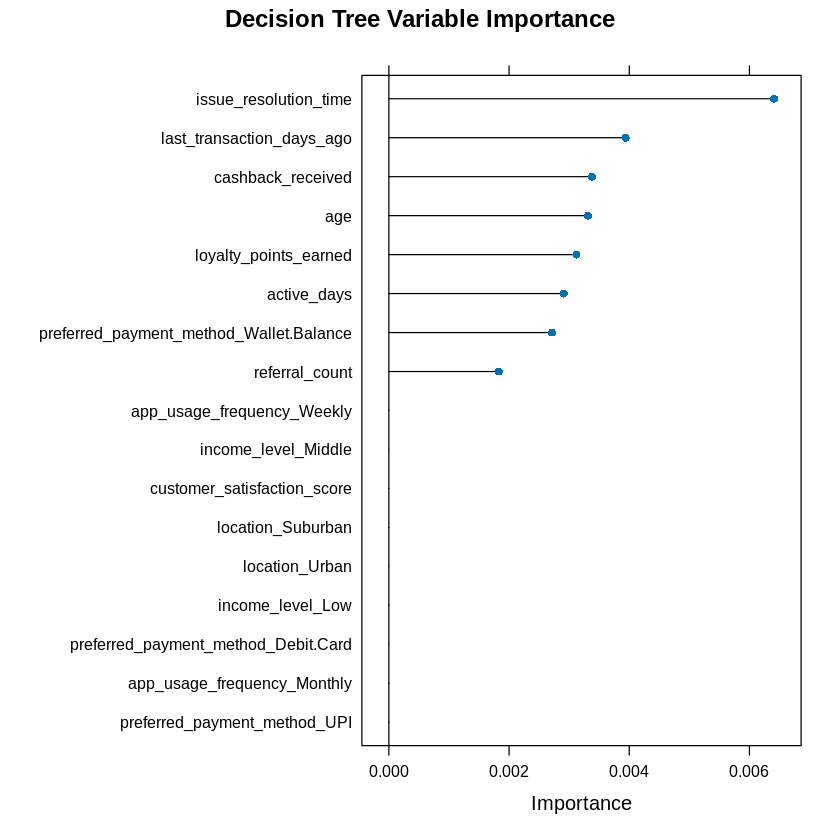

In [ ]:
# Get variable importance
importance <- varImp(dt_fit, scale = FALSE)

# Print the importance values
print(importance)

# Plot variable importance for better visualization
plot(importance, main = "Decision Tree Variable Importance")

### Removing Zero-Importance Features


In [ ]:
zero_importance_features <- c(
  "location_Urban",
  "preferred_payment_method_UPI",
  "preferred_payment_method_Debit.Card",
  "location_Suburban",
  "app_usage_frequency_Weekly",
  "income_level_Low",
  "income_level_Middle",
  "customer_satisfaction_score",
  "app_usage_frequency_Monthly"
)

X_train_tickets_reduced <- X_train_tickets %>%
  select(-one_of(zero_importance_features))

# Display the dimensions of the new training set
cat("Dimensions of original X_train_tickets:", dim(X_train_tickets), "\n")
cat("Dimensions of reduced X_train_tickets_reduced:", dim(X_train_tickets_reduced), "\n")

# Display the first few rows of the reduced dataframe to verify
head(X_train_tickets_reduced)

Dimensions of original X_train_tickets: 5672 17 
Dimensions of reduced X_train_tickets_reduced: 5672 8 


,preferred_payment_method_Wallet.Balance,age,active_days,last_transaction_days_ago,loyalty_points_earned,referral_count,cashback_received,issue_resolution_time
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,69,342,350,4083,12,3251.709,20.41650
2,1,19,4,260,4724,8,1410.801,23.65600
3,0,41,115,353,4278,47,3180.456,63.62859
4,0,21,99,93,4250,22,1135.612,64.98893
5,1,64,246,200,611,8,3172.603,62.50178
6,0,49,213,177,3843,3,2633.675,20.60209


### Refitting Decision Tree Regressor

In [ ]:
library(rpart)
library(caret)
library(rpart.plot)

#==============================
#  Set up the parameter grid
#==============================

dt_grid <- expand.grid(
  maxdepth       = c(2, 4, 6, 8)
)

#==============================
# Cross-validation settings
#==============================
ctrl <- trainControl(
  method = "cv",
  number = 5,
  search = "grid"
)

#==============================
# Train RPART Decision Tree
#==============================
set.seed(0)
dt_fit <- train(
  x = X_train_tickets_reduced,
  y = y_train_tickets,
  method = "rpart2",     # allows tuning maxdepth
  trControl = ctrl,
  tuneGrid = dt_grid,
  metric = "RMSE",
  control = rpart.control(minsplit = 2, minbucket = 1, cp = 0.0001) # Allow more complex trees initially
)

dt_fit

CART 

5672 samples
   8 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4538, 4538, 4537, 4537, 4538 
Resampling results across tuning parameters:

  maxdepth  RMSE      Rsquared      MAE     
  2         6.067389  0.0006190365  5.232491
  4         6.080759  0.0007239603  5.242295
  6         6.092224  0.0005268735  5.250982
  8         6.419484  0.0002783180  5.466040

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was maxdepth = 2.

### Visualizing the Decision Tree

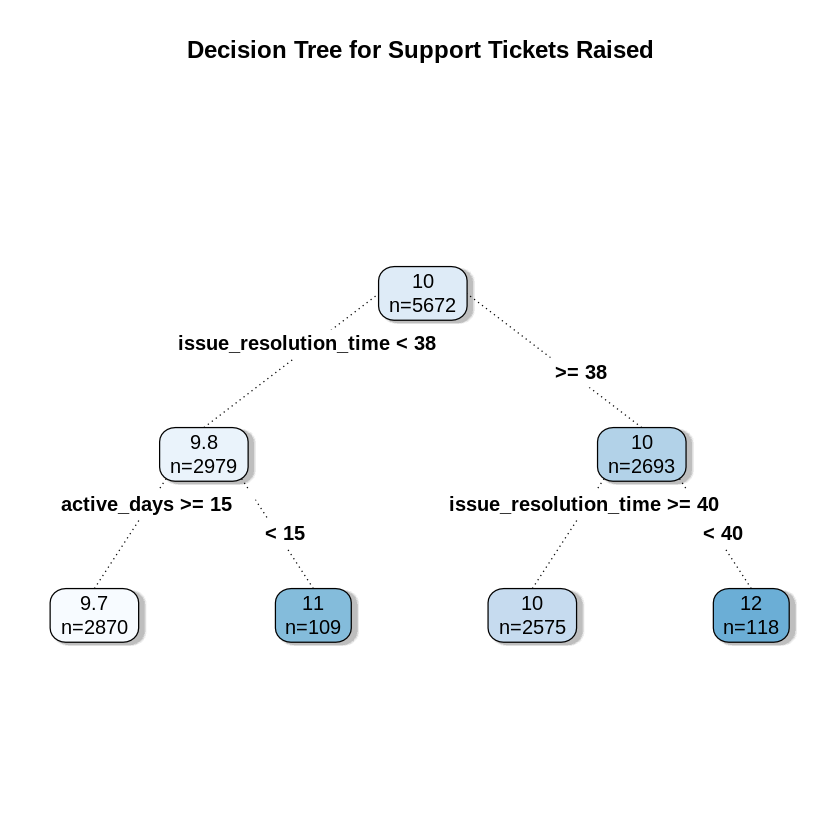

In [ ]:
# Plot the decision tree
rpart.plot::prp(dt_fit$finalModel,
                type = 4,        # Draw branch labels
                extra = 1,       # Display number of observations at each node
                varlen = 0,      # Use full variable names
                faclen = 0,      # Use full factor levels
                branch.lty = 3,  # Dashed lines for branches
                box.palette = "auto", # Color scheme for nodes
                shadow.col = "gray", # Add shadows for depth
                main = "Decision Tree for Support Tickets Raised")

In [ ]:
#

# Trying to discover Total_Spent, Avg_Transaction_value, and LTV of Each Customer In Each Node (Or the Average across each)

In [ ]:
original_data <- read.csv("/content/digital_wallet_ltv_dataset.csv")
head(original_data)

,Customer_ID,Age,Location,Income_Level,Total_Transactions,Avg_Transaction_Value,Max_Transaction_Value,Min_Transaction_Value,Total_Spent,Active_Days,Last_Transaction_Days_Ago,Loyalty_Points_Earned,Referral_Count,Cashback_Received,App_Usage_Frequency,Preferred_Payment_Method,Support_Tickets_Raised,Issue_Resolution_Time,Customer_Satisfaction_Score,LTV
,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>
1,cust_0000,54,Urban,Low,192,16736.384,60216.83,6525.815,3213386,140,209,2114,25,2224.012,Monthly,Debit Card,3,61.56859,1,327954.6
2,cust_0001,67,Suburban,High,979,14536.735,48350.10,2186.742,14231463,229,240,2960,20,4026.824,Monthly,UPI,17,60.39289,8,1437052.9
3,cust_0002,44,Urban,High,329,7061.373,32521.16,2743.407,2323192,73,21,3170,0,1441.011,Monthly,Debit Card,11,45.30558,4,241938.7
4,cust_0003,30,Rural,High,71,16426.876,17827.90,4360.785,1166308,299,285,4756,35,4365.856,Weekly,Wallet Balance,6,22.03019,1,128459.9
5,cust_0004,58,Urban,Middle,878,10800.093,17497.63,4532.873,9482481,236,329,1992,18,4161.524,Daily,UPI,18,20.63472,5,956951.4
6,cust_0005,23,Rural,Middle,741,6093.162,21310.86,2069.642,4515033,195,93,3231,5,2597.393,Daily,UPI,6,17.23454,10,467166.6


In [ ]:
library(dplyr)

# Select the desired columns from original_data
selected_ltv_data <- original_data %>%
  select(Total_Spent, Avg_Transaction_Value, LTV)

# Display the first few rows of the new variable to verify
head(selected_ltv_data)

,Total_Spent,Avg_Transaction_Value,LTV
,<dbl>,<dbl>,<dbl>
1,3213386,16736.384,327954.6
2,14231463,14536.735,1437052.9
3,2323192,7061.373,241938.7
4,1166308,16426.876,128459.9
5,9482481,10800.093,956951.4
6,4515033,6093.162,467166.6


In [ ]:
train_node_assignments <- predict(dt_fit$finalModel, newdata = X_train_tickets_reduced, type = "vector")
head(train_node_assignments)

1         2         3         4         5         6 
 9.745296 11.467890 10.135922 10.135922 10.135922  9.745296

In [ ]:
selected_ltv_data_train <- selected_ltv_data[idx_tickets, ]
head(selected_ltv_data_train)

,Total_Spent,Avg_Transaction_Value,LTV
,<dbl>,<dbl>,<dbl>
1,3213386,16736.384,327954.6
2,14231463,14536.735,1437052.9
3,2323192,7061.373,241938.7
4,1166308,16426.876,128459.9
5,9482481,10800.093,956951.4
6,4515033,6093.162,467166.6


## Extracting Node Assignments for Training Data

In [ ]:
train_node_assignments <- dt_fit$finalModel$where
head(train_node_assignments)

X1 X2 X3 X4 X5 X6 
 3  4  6  6  6  3

In [ ]:
node_ltv_data <- data.frame(
  Node = train_node_assignments,
  Total_Spent = selected_ltv_data_train$Total_Spent,
  Avg_Transaction_Value = selected_ltv_data_train$Avg_Transaction_Value,
  LTV = selected_ltv_data_train$LTV
)

average_ltv_per_node <- node_ltv_data %>%
  group_by(Node) %>%
  summarise(
    Avg_Total_Spent = mean(Total_Spent, na.rm = TRUE),
    Avg_Avg_Transaction_Value = mean(Avg_Transaction_Value, na.rm = TRUE),
    Avg_LTV = mean(LTV, na.rm = TRUE),
    Count = n()
  ) %>%
  arrange(Node)

print(average_ltv_per_node)

# A tibble: 4 × 5
   Node Avg_Total_Spent Avg_Avg_Transaction_Value Avg_LTV Count
  <int>           <dbl>                     <dbl>   <dbl> <int>
1     3        4990092.                     9827. 510630.  2870
2     4        5442271.                    10284. 556812.   109
3     6        4977441.                     9951. 509538.  2575
4     7        5328203.                    10033. 544445.   118


**Key Observations:**

*   **Node 4** appears to represent a segment of customers with the highest average 'Total_Spent', 'Avg_Transaction_Value', and 'LTV'. This node could correspond to high-value customers.
*   **Nodes 3 and 6** show relatively lower average LTV metrics compared to Nodes 4 and 7, indicating these nodes might represent customer segments with lower LTV.
*   **Node 7** also shows higher LTV metrics than nodes 3 and 6, but slightly lower than node 4.

# Regression on Customer Satisfaction Score

In [ ]:
lin_score <- train_linear_model(X_train_score, y_train_score,
                                  scale = "standard")

lin_score   # print the CV summary (λ, α, RMSE, etc.

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

5672 samples
  17 predictor

Pre-processing: centered (17), scaled (17) 
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 3783, 3780, 3781 
Resampling results across tuning parameters:

  alpha  lambda  RMSE      Rsquared      MAE     
  0.0    1e-01   2.865040  2.367165e-04  2.478979
  0.0    1e+00   2.860402  1.880832e-04  2.478154
  0.0    1e+01   2.855044  1.491501e-04  2.477140
  0.0    1e+02   2.854443  8.149878e-05  2.476895
  0.0    1e+03   2.854392           NaN  2.476807
  0.3    1e-01   2.858864  2.302281e-04  2.477938
  0.3    1e+00   2.854392           NaN  2.476807
  0.3    1e+01   2.854392           NaN  2.476807
  0.3    1e+02   2.854392           NaN  2.476807
  0.3    1e+03   2.854392           NaN  2.476807
  0.5    1e-01   2.857237  3.900510e-04  2.478044
  0.5    1e+00   2.854392           NaN  2.476807
  0.5    1e+01   2.854392           NaN  2.476807
  0.5    1e+02   2.854392           NaN  2.476807
  0.5    1e+03   2.854392           NaN  

# Regression Tree Interpretability and Understanding What Features Most Influential on Customer Satisfaction Score

In [ ]:
library(rpart)
library(caret)
library(rpart.plot)

#==============================
#  Set up the parameter grid
#==============================

dt_grid <- expand.grid(
  maxdepth       = c(2, 4, 6, 8)
)

#==============================
# Cross-validation settings
#==============================
ctrl <- trainControl(
  method = "cv",
  number = 5,
  search = "grid"
)

#==============================
# Train RPART Decision Tree
#==============================
set.seed(0)
dt_fit <- train(
  x = X_train_score,
  y = y_train_score,
  method = "rpart2",     # allows tuning maxdepth
  trControl = ctrl,
  tuneGrid = dt_grid,
  metric = "RMSE",
  control = rpart.control(minsplit = 2, minbucket = 1, cp = 0.0001) # Allow more complex trees initially
)

dt_fit

CART 

5672 samples
  17 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4539, 4537, 4537, 4537, 4538 
Resampling results across tuning parameters:

  maxdepth  RMSE      Rsquared      MAE     
  2         2.877864  0.0007567173  2.485921
  4         2.877722  0.0009618539  2.485418
  6         2.877722  0.0009618539  2.485418
  8         3.023164  0.0008611821  2.568423

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was maxdepth = 4.

### Analyzing Variable Importance

rpart2 variable importance

                                         Overall
issue_resolution_time                   1.887236
referral_count                          1.479262
last_transaction_days_ago               0.986100
loyalty_points_earned                   0.835961
active_days                             0.776789
location_Suburban                       0.693760
cashback_received                       0.624443
age                                     0.337931
location_Urban                          0.268881
app_usage_frequency_Monthly             0.176896
preferred_payment_method_Wallet.Balance 0.129750
support_tickets_raised                  0.014767
preferred_payment_method_Debit.Card     0.013523
income_level_Low                        0.002058
income_level_Middle                     0.001049
preferred_payment_method_UPI            0.000000
app_usage_frequency_Weekly              0.000000


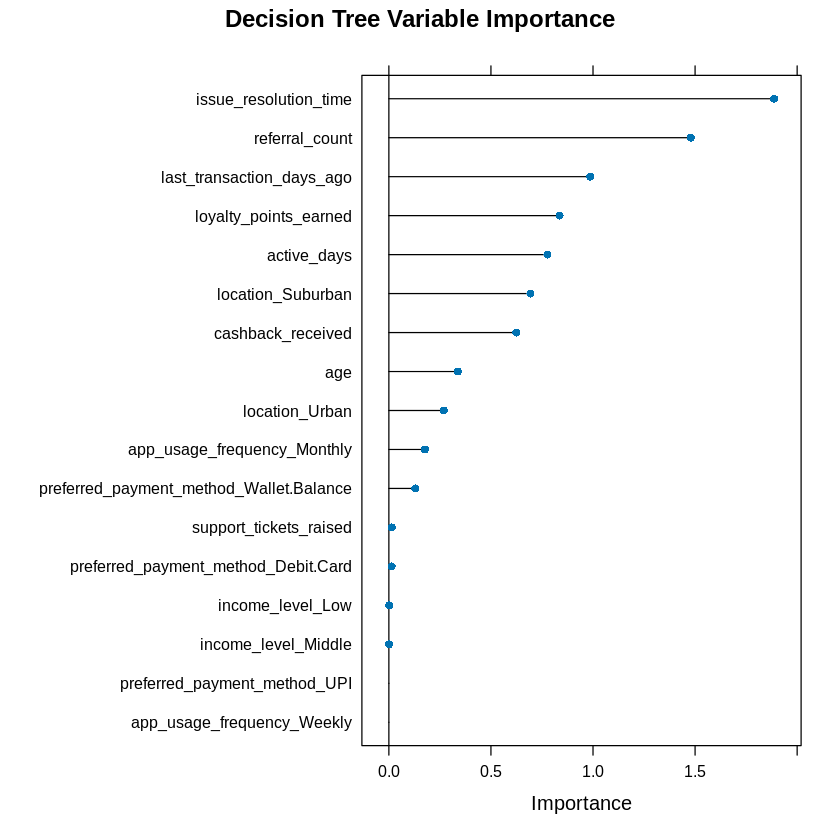

In [ ]:
# Get variable importance
importance <- varImp(dt_fit, scale = FALSE)

# Print the importance values
print(importance)

# Plot variable importance for better visualization
plot(importance, main = "Decision Tree Variable Importance")

Might be worth keying in on issue resolution time

### Visualizing the Decision Tree

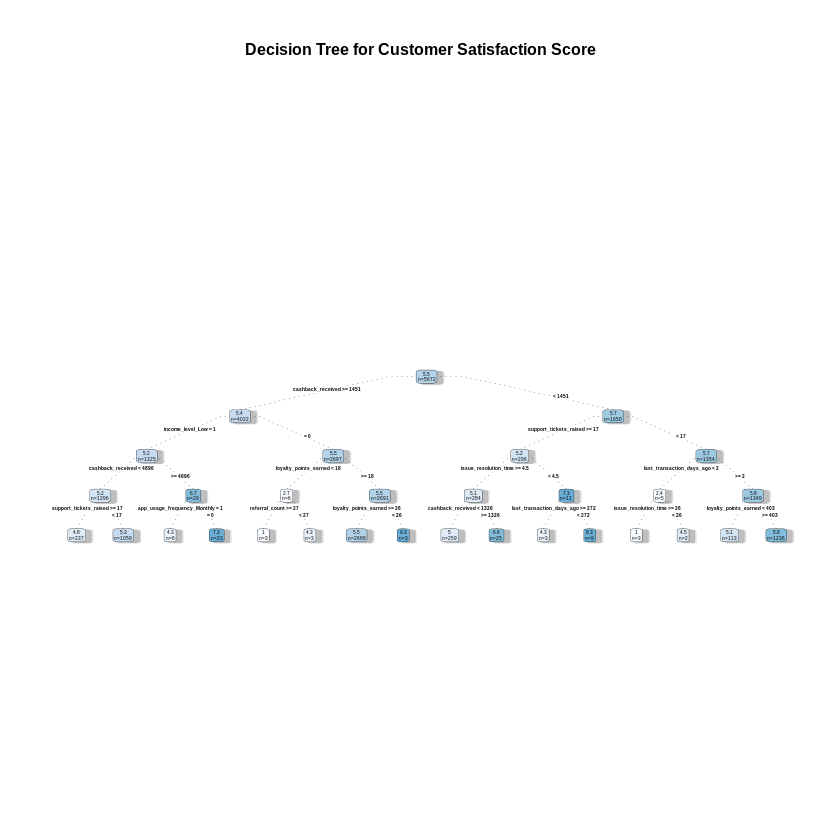

In [ ]:
# Plot the decision tree
rpart.plot::prp(dt_fit$finalModel,
                type = 4,        # Draw branch labels
                extra = 1,       # Display number of observations at each node
                varlen = 0,      # Use full variable names
                faclen = 0,      # Use full factor levels
                branch.lty = 3,  # Dashed lines for branches
                box.palette = "auto", # Color scheme for nodes
                shadow.col = "gray", # Add shadows for depth
                main = "Decision Tree for Customer Satisfaction Score")

In [ ]:
# visualizing with a depth of 2 (forcing a depth of 2)

In [ ]:
library(rpart)
library(caret)
library(rpart.plot)

#==============================
#  Set up the parameter grid
#==============================

dt_grid <- expand.grid(
  maxdepth       = 2
)

#==============================
# Cross-validation settings
#==============================
ctrl <- trainControl(
  method = "cv",
  number = 5,
  search = "grid"
)

#==============================
# Train RPART Decision Tree
#==============================
set.seed(0)
dt_fit <- train(
  x = X_train_score,
  y = y_train_score,
  method = "rpart2",     # allows tuning maxdepth
  trControl = ctrl,
  tuneGrid = dt_grid,
  metric = "RMSE",
  control = rpart.control(minsplit = 2, minbucket = 1, cp = 0.0001) # Allow more complex trees initially
)

dt_fit

CART 

5672 samples
  17 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4539, 4537, 4537, 4537, 4538 
Resampling results:

  RMSE     Rsquared     MAE     
  2.86102  0.000421873  2.477844

Tuning parameter 'maxdepth' was held constant at a value of 2

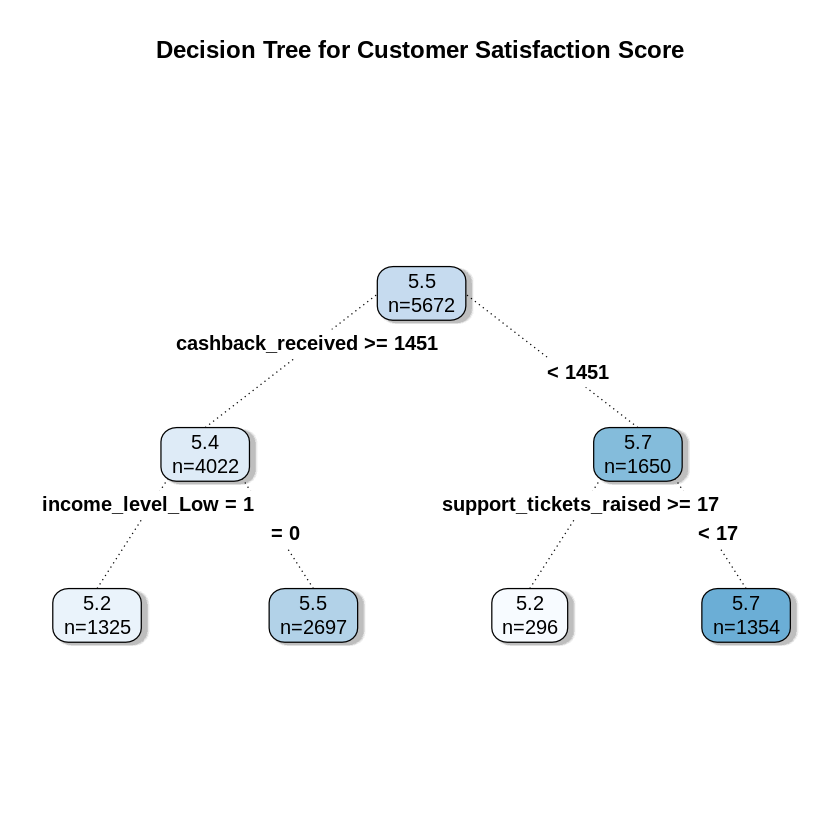

In [ ]:
# Plotting the decision tree
rpart.plot::prp(dt_fit$finalModel,
                type = 4,        # Draw branch labels
                extra = 1,       # Display number of observations at each node
                varlen = 0,      # Use full variable names
                faclen = 0,      # Use full factor levels
                branch.lty = 3,  # Dashed lines for branches
                box.palette = "auto", # Color scheme for nodes
                shadow.col = "gray", # Add shadows for depth
                main = "Decision Tree for Customer Satisfaction Score")

In [ ]:
# very low average customer satisfaction across all nodes

# Regression on Issue Resolution Time

In [ ]:
# --- Support tickets regression design matrix ---
X_for_issue <- data_wo %>% select(-issue_resolution_time)
y_for_issue <- data_wo$issue_resolution_time

In [ ]:
set.seed(0)
idx_issue <- createDataPartition(y_for_issue, p = 0.9, list = FALSE)

X_train_issue <- X_for_issue[idx_issue, ]
X_test_issue  <- X_for_issue[-idx_issue, ]
y_train_issue <- y_for_issue[idx_issue]
y_test_issue  <- y_for_issue[-idx_issue]

In [ ]:
lin_issue <- train_linear_model(X_train_issue, y_train_issue,
                                scale = "standard")

lin_issue # print the CV summary (λ, α, RMSE, etc.)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

5672 samples
  17 predictor

Pre-processing: centered (17), scaled (17) 
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 3781, 3781, 3782 
Resampling results across tuning parameters:

  alpha  lambda  RMSE      Rsquared      MAE     
  0.0    1e-01   20.41342  1.359485e-04  17.65094
  0.0    1e+00   20.40995  1.255426e-04  17.64911
  0.0    1e+01   20.39536  8.336937e-05  17.64312
  0.0    1e+02   20.38650  4.965794e-05  17.64132
  0.0    1e+03   20.38660           NaN  17.64212
  0.3    1e-01   20.41007  9.216527e-05  17.64966
  0.3    1e+00   20.39085  6.417348e-06  17.64252
  0.3    1e+01   20.38660           NaN  17.64212
  0.3    1e+02   20.38660           NaN  17.64212
  0.3    1e+03   20.38660           NaN  17.64212
  0.5    1e-01   20.40801  7.005999e-05  17.64886
  0.5    1e+00   20.38737  1.146191e-04  17.64224
  0.5    1e+01   20.38660           NaN  17.64212
  0.5    1e+02   20.38660           NaN  17.64212
  0.5    1e+03   20.38660           NaN  

In [ ]:
# Get the best lambda value from the tuned model
best_lambda <- lin_issue$bestTune$lambda

# Extract coefficients for the best lambda
coefficients <- coef(lin_issue$finalModel, s = best_lambda)

# Convert the sparse matrix of coefficients to a data frame
coef_df <- as.data.frame(as.matrix(coefficients))

# Rename the column to 'Coefficient'
colnames(coef_df) <- c("Coefficient")

# Add a column for feature names (row names)
coef_df$Feature <- rownames(coef_df)

# Calculate absolute values of coefficients
coef_df$Abs_Coefficient <- abs(coef_df$Coefficient)


coef_df_sorted <- coef_df %>%
  filter(Feature != "(Intercept)") %>%
  arrange(desc(Abs_Coefficient))

# Display the sorted coefficients
print(coef_df_sorted)


                                         Coefficient
support_tickets_raised                   0.084960066
preferred_payment_method_UPI            -0.068711295
cashback_received                       -0.061643871
app_usage_frequency_Monthly              0.056947008
referral_count                          -0.051915493
app_usage_frequency_Weekly               0.047281467
loyalty_points_earned                   -0.036870483
income_level_Low                        -0.035621101
last_transaction_days_ago                0.024767267
location_Suburban                       -0.021939838
customer_satisfaction_score              0.019000320
age                                     -0.018699055
location_Urban                           0.015107390
preferred_payment_method_Wallet.Balance -0.014379929
income_level_Middle                     -0.008908482
active_days                              0.007846215
preferred_payment_method_Debit.Card      0.005104719
                                              

In [ ]:
library(rpart)
library(caret)
library(rpart.plot)

#==============================
#  Set up the parameter grid
#==============================

dt_grid <- expand.grid(
  maxdepth       = c(2, 4, 6, 8)
)

#==============================
# Cross-validation settings
#==============================
ctrl <- trainControl(
  method = "cv",
  number = 5,
  search = "grid"
)

#==============================
# Train RPART Decision Tree
#==============================
set.seed(0)
dt_fit <- train(
  x = X_train_issue,
  y = y_train_issue,
  method = "rpart2",     # allows tuning maxdepth
  trControl = ctrl,
  tuneGrid = dt_grid,
  metric = "RMSE",
  control = rpart.control(minsplit = 2, minbucket = 1, cp = 0.0001) # Allow more complex trees initially
)

dt_fit

CART 

5672 samples
  17 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4539, 4536, 4536, 4537, 4540 
Resampling results across tuning parameters:

  maxdepth  RMSE      Rsquared      MAE     
  2         20.48129  0.0019818926  17.71869
  4         20.49226  0.0005114396  17.72628
  6         20.57727  0.0005640408  17.76851
  8         21.69410  0.0014314179  18.39956

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was maxdepth = 2.

rpart2 variable importance

                                         Overall
cashback_received                       0.006494
loyalty_points_earned                   0.005776
last_transaction_days_ago               0.005126
support_tickets_raised                  0.004170
income_level_Middle                     0.002542
referral_count                          0.001883
income_level_Low                        0.000836
app_usage_frequency_Weekly              0.000000
app_usage_frequency_Monthly             0.000000
location_Urban                          0.000000
preferred_payment_method_UPI            0.000000
preferred_payment_method_Debit.Card     0.000000
location_Suburban                       0.000000
customer_satisfaction_score             0.000000
preferred_payment_method_Wallet.Balance 0.000000
age                                     0.000000
active_days                             0.000000


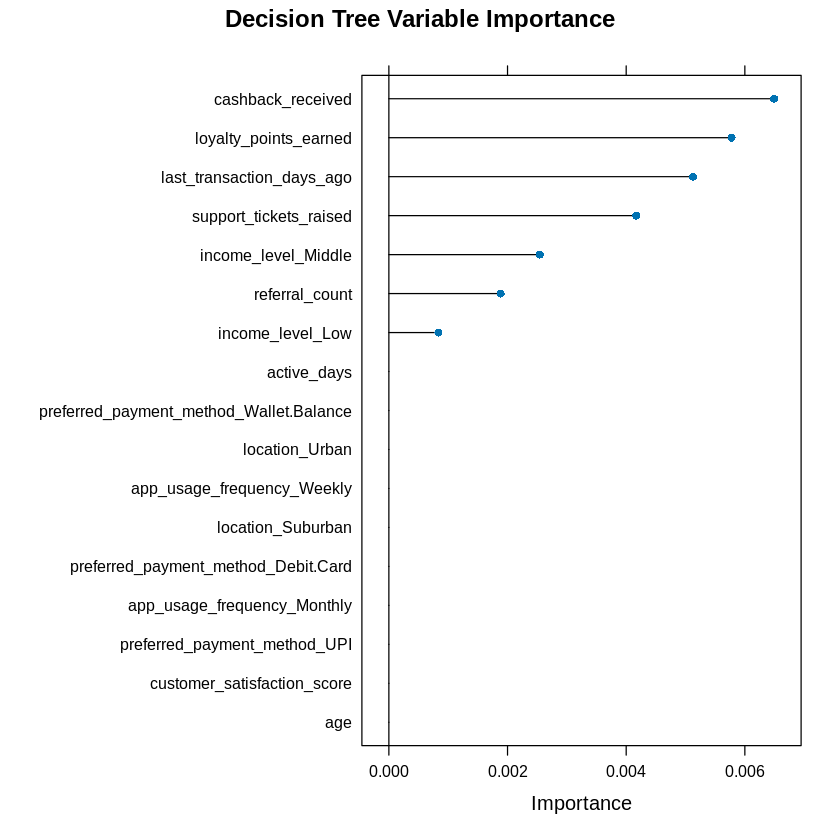

In [ ]:
# Get variable importance
importance <- varImp(dt_fit, scale = FALSE)

# Print the importance values
print(importance)

# Plot variable importance for better visualization
plot(importance, main = "Decision Tree Variable Importance")